In [28]:
%matplotlib inline
import numpy as np
from ggplot import *
import pandas as pd
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix

import nltk
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from utils import detect_lang

In [2]:
def add_language_to_reviews(df):
    df_reviews = pd.read_csv('data/reviews.csv')
    
    df_reviews["comments2"] = df_reviews.comments.apply(lambda x:str(x).decode('utf-8'))
    df_reviews['language']= df_reviews.comments2.apply(detect_lang)
    df_reviews.to_csv("data/reviews_with_lang.csv")
    

In [3]:
df_reviews = pd.read_csv('data/reviews_with_lang.csv')
df_reviews_eng = df_reviews[df_reviews.language=='en']

df_listing = pd.read_csv('data/listings.csv')


In [4]:
df_listing.columns

Index([u'id', u'listing_url', u'scrape_id', u'last_scraped', u'name',
       u'summary', u'space', u'description', u'experiences_offered',
       u'neighborhood_overview', u'notes', u'transit', u'access',
       u'interaction', u'house_rules', u'thumbnail_url', u'medium_url',
       u'picture_url', u'xl_picture_url', u'host_id', u'host_url',
       u'host_name', u'host_since', u'host_location', u'host_about',
       u'host_response_time', u'host_response_rate', u'host_acceptance_rate',
       u'host_is_superhost', u'host_thumbnail_url', u'host_picture_url',
       u'host_neighbourhood', u'host_listings_count',
       u'host_total_listings_count', u'host_verifications',
       u'host_has_profile_pic', u'host_identity_verified', u'street',
       u'neighbourhood', u'neighbourhood_cleansed',
       u'neighbourhood_group_cleansed', u'city', u'state', u'zipcode',
       u'market', u'smart_location', u'country_code', u'country', u'latitude',
       u'longitude', u'is_location_exact', u'prope

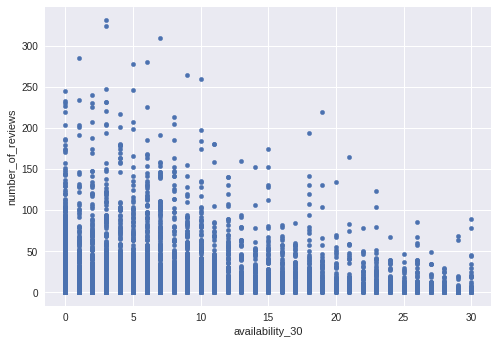

In [5]:
df_listing[df_listing.room_type=='Entire home/apt'].plot(kind='scatter',x='availability_30',y='number_of_reviews')

In [6]:
df_listing.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [7]:
df_reviews_eng = pd.merge(df_reviews_eng,df_listing[['id','review_scores_rating','review_scores_cleanliness','room_type','availability_30','availability_90','reviews_per_month']],left_on='listing_id',right_on='id')

In [8]:
df_reviews_eng.head()

,Unnamed: 0,listing_id,id_x,date,reviewer_id,reviewer_name,comments,language,id_y,review_scores_rating,review_scores_cleanliness,room_type,availability_30,availability_90,reviews_per_month
0,1,7878281,50115386,2015-10-09,45018962,Rotem,"AMAZING hosting, we arrived to Benita's appart...",en,7878281,99.0,10.0,Entire home/apt,6,6,0.69
1,3,7878281,58376102,2016-01-02,6789115,Nicola,"This apartment was beautiful, spacious, warm a...",en,7878281,99.0,10.0,Entire home/apt,6,6,0.69
2,4,7878281,71814574,2016-04-28,63494941,Claudio,BENITA AND KLEMENS WERE VERY KIND WITH US. THE...,en,7878281,99.0,10.0,Entire home/apt,6,6,0.69
3,5,7878281,74568125,2016-05-15,57750113,Sandeep,Yes. Klemens came with a bouquet of flowers an...,en,7878281,99.0,10.0,Entire home/apt,6,6,0.69
4,7,7878281,86698077,2016-07-17,19899121,Brian,Great experience. Hosts were responsive and fr...,en,7878281,99.0,10.0,Entire home/apt,6,6,0.69


In [9]:
groupy_per_lang = df_reviews.groupby('language').comments.count().sort_values(ascending = False)

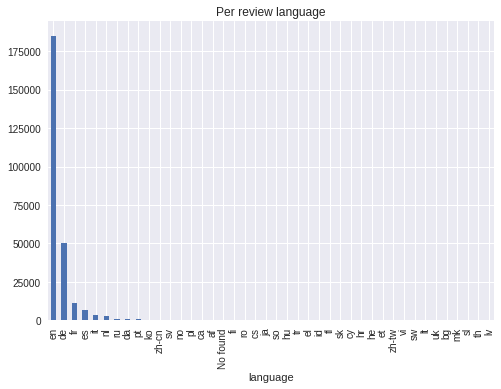

In [10]:
groupy_per_lang.plot.bar(title="Per review language")

In [11]:
def concat_comments(x):
    return "%s" % '- '.join(x)

df_reviews_eng = df_reviews_eng[df_reviews_eng.room_type=='Entire home/apt']
df_reviews_eng = df_reviews_eng[~df_reviews_eng.review_scores_rating.isnull()]
df_reviews_eng = df_reviews_eng[~df_reviews_eng.comments.str.contains('The host canceled this reservation')]
groupy = df_reviews_eng.groupby('listing_id').agg({'comments': [concat_comments,'count'], 'review_scores_rating': 'mean', 'availability_30':'mean','availability_90':'mean','reviews_per_month':'mean'})
#groupy  = df_rewiews_eng.groupby('listing_id')['comments','review_scores_cleanliness'].apply(lambda x: "%s" % ', '.join(x))
raw_text = groupy.comments.values
groupy.columns = ["_".join(x) for x in groupy.columns.ravel()]

In [ ]:
ggplot(groupy,aes(x='availability_90_mean',y='reviews_per_month_mean'))+geom_point()

In [ ]:
raw_text = groupy.comments_concat_comments.values

In [26]:
porter = nltk.stem.porter.PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

nltk.download('stopwords')

stop = nltk.corpus.stopwords.words('english')


vectorizer = TfidfVectorizer(ngram_range=(2,2),tokenizer=tokenizer_porter,stop_words=stop,max_features=3000)
X_vectorized = vectorizer.fit_transform(groupy.comments_concat_comments.values).todense()

from sklearn.naive_bayes import MultinomialNB

target = np.where(groupy.review_scores_rating_mean>90,'good','bad')

clf = MultinomialNB().fit(X_vectorized, target)

[nltk_data] Downloading package stopwords to /home/ramon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
predicted = clf.predict(X_vectorized)

In [36]:
print confusion_matrix(predicted,target)

[[5467 1731]
 [  16  327]]


In [38]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)
        
show_most_informative_features(vectorizer,clf)

	-9.6819	wa broken      		-4.7809	wa veri        
	-9.6096	uwe wa         		-5.1226	apart wa       
	-9.4839	gili wa        		-5.3998	veri nice      
	-9.4075	shower curtain 		-5.6571	wa great       
	-9.3152	didn't work    		-5.6994	would definit  
	-9.3130	didn't realli  		-5.7238	recommend thi  
	-9.3126	central station		-5.7681	highli recommend
	-9.2832	overal good    		-5.7978	everyth wa     
	-9.2826	toilet paper   		-5.8797	wa realli      
	-9.2762	ron wa         		-5.9039	everyth need   
	-9.2350	door wa        		-5.9320	wa perfect     
	-9.2263	howev wa       		-5.9572	place wa       
	-9.2181	stephan wa     		-5.9638	flat wa        
	-9.1863	- alex         		-6.0473	veri clean     
	-9.1636	bit noisi      		-6.0525	apart veri     
	-9.1544	contact host   		-6.0628	public transport
	-9.1249	wa wifi        		-6.0631	definit recommend
	-9.1195	didn't know    		-6.0682	veri close     
	-9.1184	onli complaint 		-6.1020	veri well      
	-9.1141	would nice     		-6.1194	veri help   

In [ ]:
pca = PCA(n_components=20).fit(X_vectorized)

print pca.explained_variance_ratio_.sum()
print pca.explained_variance_ratio_*100

In [ ]:
data2D = pca.transform(X_vectorized)
groupy['pc1']=data2D[:,0]
groupy['pc2']=data2D[:,1]

In [ ]:
cmap = cm.get_cmap('Spectral')
data2D = pca.transform(X_vectorized)
groupy.plot(kind='scatter',x='pc1', y='pc2',alpha=.2)

In [ ]:
df_reviews_eng.review_scores_rating.hist(bins=100)

In [ ]:
nltk.download()

In [16]:
porter = nltk.stem.porter.PorterStemmer()
def stem_stop(x):
    x = x.replace(r'[^a-zA-Z\d\s:]','')
    x = x.split(' ')
    x = [word for word in x if word not in set(nltk.corpus.stopwords.words("english"))]
    
    x = ' '.join(x)
    x = [porter.stem(word.decode('utf-8')) for word in x.split()]
 
    return x

test_df = groupy.head(10)

test_df['features']= test_df.comments_concat_comments.apply(stem_stop)
test_df['score']= np.where(test_df.review_scores_rating_mean>90,'good','bad')
test_df['Labeled_Feature'] = zip(test_df['features'],test_df['score'])

/home/ramon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ramon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ramon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable